In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor

# Load the datasets
train_data_path = '/Users/mac/Downloads/train.csv'
test_data_path = '/Users/mac/Downloads/test.csv'
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

# Convert 'date' columns to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Encode the 'family' categorical data
label_encoder = LabelEncoder()
train_df['family_encoded'] = label_encoder.fit_transform(train_df['family'])
test_df['family_encoded'] = label_encoder.transform(test_df['family'])

# Normalize the 'sales' and 'onpromotion' features
sales_scaler = MinMaxScaler()
onpromotion_scaler = MinMaxScaler()
train_df['sales'] = sales_scaler.fit_transform(train_df[['sales']])
train_df['onpromotion'] = onpromotion_scaler.fit_transform(train_df[['onpromotion']])
test_df['onpromotion'] = onpromotion_scaler.transform(test_df[['onpromotion']])

# Aggregate data to monthly sales per store per family
train_df['year_month'] = train_df['date'].dt.to_period('M')
test_df['year_month'] = test_df['date'].dt.to_period('M')
monthly_train_df = train_df.groupby(['year_month', 'store_nbr', 'family_encoded']).agg({
    'sales': 'sum',
    'onpromotion': 'mean'
}).reset_index()
monthly_test_df = test_df.groupby(['year_month', 'store_nbr', 'family_encoded']).agg({
    'onpromotion': 'mean'
}).reset_index()

# Features and target for the model
features = monthly_train_df[['store_nbr', 'family_encoded', 'onpromotion']]
target = monthly_train_df['sales']

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the KNeighborsRegressor
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

# Cross-validate the model
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

# Make predictions on the test set
test_features = monthly_test_df[['store_nbr', 'family_encoded', 'onpromotion']]
test_predictions = knn_model.predict(test_features)

# Reverse the normalization to get actual sales predictions
predicted_sales = sales_scaler.inverse_transform(test_predictions.reshape(-1, 1))
monthly_test_df['predicted_sales'] = predicted_sales

# Output results
print("CV RMSE Scores:", cv_rmse_scores)
print("Average CV RMSE:", cv_rmse_scores.mean())
print(monthly_test_df.head())


CV RMSE Scores: [0.05628266 0.05427668 0.05424351 0.05775606 0.05683406]
Average CV RMSE: 0.05587859361767979
  year_month  store_nbr  family_encoded  onpromotion  predicted_sales
0    2017-08          1               0     0.000000            113.8
1    2017-08          1               1     0.000000              0.0
2    2017-08          1               2     0.001096             87.4
3    2017-08          1               3     0.030617          61424.8
4    2017-08          1               4     0.000000              0.0


Validation RMSE: 0.05455625992990923


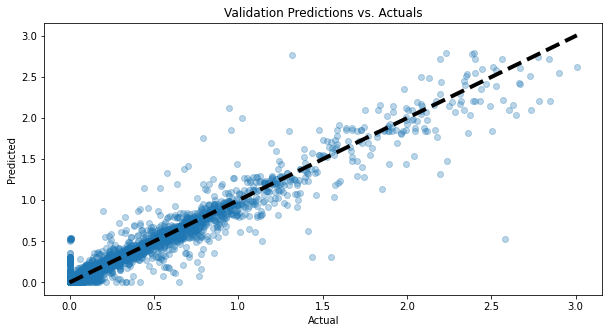

In [7]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Predict on the validation set
val_predictions = knn_model.predict(X_val)

# Calculate the RMSE on the validation set
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

# Print the validation RMSE
print("Validation RMSE:", val_rmse)

# Optionally, plot actual vs predicted values for further insight
plt.figure(figsize=(10, 5))
plt.scatter(y_val, val_predictions, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)  # Perfect prediction line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Validation Predictions vs. Actuals')
plt.show()
#Scatter Plot: Each point represents an observation from the validation set. Points closer to the dashed line indicate accurate predictions, where the predicted value is close to the actual value.
#Perfect Prediction Line: This line shows where the points would lie if every prediction was perfectly accurate. The closer the scatter points are to this line, the better the model's predictive accuracy.

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the validation set
val_predictions = knn_model.predict(X_val)

# Calculate MSE
val_mse = mean_squared_error(y_val, val_predictions)

# Calculate RMSE
val_rmse = np.sqrt(val_mse)

# Calculate MAE
val_mae = mean_absolute_error(y_val, val_predictions)

# Print the results
print("Validation MSE:", val_mse)
print("Validation RMSE:", val_rmse)
print("Validation MAE:", val_mae)


Validation MSE: 0.0029763854975398195
Validation RMSE: 0.05455625992990923
Validation MAE: 0.013460346803787633


In [4]:
# here is without normalizer
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the datasets
train_data_path = '/Users/mac/Downloads/train.csv'
test_data_path = '/Users/mac/Downloads/test.csv'
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

# Convert 'date' columns to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Encode the 'family' categorical data
label_encoder = LabelEncoder()
train_df['family_encoded'] = label_encoder.fit_transform(train_df['family'])
test_df['family_encoded'] = label_encoder.transform(test_df['family'])

# Normalize only the 'onpromotion' feature
onpromotion_scaler = MinMaxScaler()
train_df['onpromotion'] = onpromotion_scaler.fit_transform(train_df[['onpromotion']])
test_df['onpromotion'] = onpromotion_scaler.transform(test_df[['onpromotion']])

# Aggregate data to monthly sales per store per family
train_df['year_month'] = train_df['date'].dt.to_period('M')
test_df['year_month'] = test_df['date'].dt.to_period('M')
monthly_train_df = train_df.groupby(['year_month', 'store_nbr', 'family_encoded']).agg({
    'sales': 'sum',  # Keeping sales as is, not normalized
    'onpromotion': 'mean'
}).reset_index()
monthly_test_df = test_df.groupby(['year_month', 'store_nbr', 'family_encoded']).agg({
    'onpromotion': 'mean'
}).reset_index()

# Features and target for the model
features = monthly_train_df[['store_nbr', 'family_encoded', 'onpromotion']]
target = monthly_train_df['sales']

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the KNeighborsRegressor
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

# Predict on the validation set
val_predictions = knn_model.predict(X_val)

# Calculate MSE
val_mse = mean_squared_error(y_val, val_predictions)

# Calculate RMSE
val_rmse = np.sqrt(val_mse)

# Calculate MAE
val_mae = mean_absolute_error(y_val, val_predictions)

# Print the results
print("Validation MSE:", val_mse)
print("Validation RMSE:", val_rmse)
print("Validation MAE:", val_mae)


Validation MSE: 46295682.50084684
Validation RMSE: 6804.093069678489
Validation MAE: 1678.7340723279822
